In [12]:
# !unzip -q "../data/bracket_white.zip" -d "../data/"

### Visualize data

../data/bracket_white/test/defective_painting/012.png
../data/bracket_white/ground_truth/defective_painting/012_mask.png
Showing defect sample: defective_painting: ('012.png', '012_mask.png')


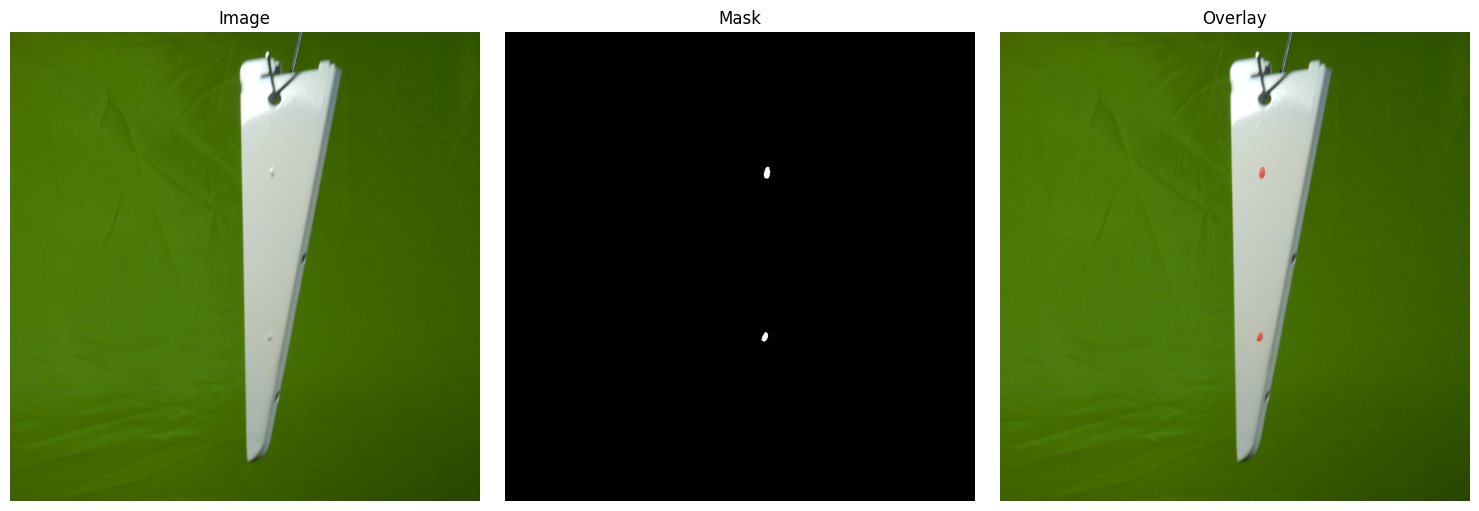

In [17]:
import os
import cv2
import matplotlib.pyplot as plt
import random
import numpy as np

DATA_DIR = '../data/bracket_white'

TEST_DIR = os.path.join(DATA_DIR, 'test')
GT_DIR = os.path.join(DATA_DIR, 'ground_truth')
TRAIN_DIR = os.path.join(DATA_DIR, 'train')

def show_image_and_mask(img_path, mask_path=None, title=""):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if mask_path and os.path.exists(mask_path):
        mask = cv2.imread(mask_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)  

        mask_bool = np.any(mask > 0, axis=-1)  # Shape (1024, 1024)

        # red overlay
        overlay = img.copy()
        overlay[mask_bool] = [255, 0, 0]  

        alpha = 0.5
        blended = cv2.addWeighted(img, 1 - alpha, overlay, alpha, 0)

        # Plots
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(img)
        ax[0].set_title("Image")

        ax[1].imshow(mask)
        ax[1].set_title("Mask")

        ax[2].imshow(blended)
        ax[2].set_title("Overlay")

        for a in ax:
            a.axis('off')
    else:
        plt.figure(figsize=(5, 5))
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


sub_folders = ['defective_painting', 'scratches'][0] # white- defective_painting, scratches;
test_sample_dir = os.path.join(TEST_DIR, sub_folders)
gt_sample_dir = os.path.join(GT_DIR, sub_folders)

sample_img =os.listdir(test_sample_dir)[0]
img_path = os.path.join(test_sample_dir, sample_img)
sample_mask = f"{sample_img.split('.')[0]}_mask.png"
mask_path = os.path.join(gt_sample_dir, sample_mask)
print(img_path)
print(mask_path)
print(f"Showing defect sample: {sub_folders}: {sample_img, sample_mask}")
show_image_and_mask(img_path, mask_path)


In [18]:
# # Generate empty masks for good images

# # Paths
# GOOD_IMG_DIR = "../data/bracket_white/test/good"
# MASK_SAVE_DIR = "../data/bracket_white/ground_truth/good"

# os.makedirs(MASK_SAVE_DIR, exist_ok=True)
# good_images = os.listdir(GOOD_IMG_DIR)  #[:20]

# print(f"Number of good images: {len(good_images)}")

# for img_name in good_images:
#     if img_name.lower().endswith((".png", ".jpg", ".jpeg")):
#         img_path = os.path.join(GOOD_IMG_DIR, img_name)
#         img = cv2.imread(img_path)

#         if img is None:
#             print(f"Failed to load image: {img_name}")
#             continue

#         height, width = img.shape[:2]

#         # create black mask (all zeros)
#         mask = np.zeros((height, width, 3), dtype=np.uint8)

#         base_name = os.path.splitext(img_name)[0]
#         mask_name = f"{base_name}_mask.png"
#         mask_path = os.path.join(MASK_SAVE_DIR, mask_name)

#         cv2.imwrite(mask_path, mask)

#         print(f"Saved: {mask_path}")

In [19]:
# def get_combined_image_mask_pairs(data_dir, defect_types):
#     image_paths = []
#     mask_paths = []

#     for defect in defect_types:
#         image_dir = os.path.join(data_dir, 'test', defect)
#         mask_dir  = os.path.join(data_dir, 'ground_truth', defect)

#         for img_file in os.listdir(image_dir):
#             if img_file.endswith((".png", ".jpg")):
#                 img_path = os.path.join(image_dir, img_file)
#                 mask_file = img_file.split('.')[0] + "_mask.png"
#                 mask_path = os.path.join(mask_dir, mask_file)

#                 if os.path.exists(mask_path):
#                     image_paths.append(img_path)
#                     mask_paths.append(mask_path)
                    
#         print(f"Defect: {defect}  |  num samples:  {len(os.listdir(image_dir))}")

#     return image_paths, mask_paths

# DATA_DIR = '../data/bracket_white'
# defect_types = ['defective_painting', 'scratches', 'good']
# image_paths, mask_paths = get_combined_image_mask_pairs(DATA_DIR, defect_types)
# print(f"Loaded {len(image_paths)} combined image-mask pairs.")


### Visualize augmentation

In [21]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

image_size = 512

train_transform = A.Compose([
    A.Resize(image_size, image_size),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.05, p= 0.05),
    ### A.GaussNoise(p=0.05),
    A.ElasticTransform(alpha=1, sigma=50, p=0.3),

    ### A.GridDistortion(p=0.3),
    A.MotionBlur(blur_limit=3, p=0.2),
    # A.Normalize(mean=(0.485, 0.456, 0.406),
    #             std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])


In [22]:
from torch.utils.data import Dataset
import cv2
import numpy as np

class SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(self.mask_paths[idx])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

        binary_mask = np.any(mask > 10, axis=-1).astype(np.uint8)

        if self.transform:
            augmented = self.transform(image=image, mask=binary_mask)
            image = augmented["image"]  # [3, H, W]
            mask = augmented["mask"].unsqueeze(0)  # [1, H, W]

        return image, mask.float()


In [23]:
def get_combined_image_mask_pairs(data_dir, defect_types):
    image_paths = []
    mask_paths = []

    for defect in defect_types:
        image_dir = os.path.join(data_dir, 'test', defect)
        mask_dir  = os.path.join(data_dir, 'ground_truth', defect)

        for img_file in os.listdir(image_dir):
            if img_file.endswith((".png", ".jpg")):
                img_path = os.path.join(image_dir, img_file)
                mask_file = img_file.split('.')[0] + "_mask.png"
                mask_path = os.path.join(mask_dir, mask_file)

                if os.path.exists(mask_path):
                    image_paths.append(img_path)
                    mask_paths.append(mask_path)
                    
        print(f"Defect: {defect}  |  num samples:  {len(os.listdir(image_dir))}")

    return image_paths, mask_paths

Defect: defective_painting  |  num samples:  13
Defect: scratches  |  num samples:  17
Defect: good  |  num samples:  30


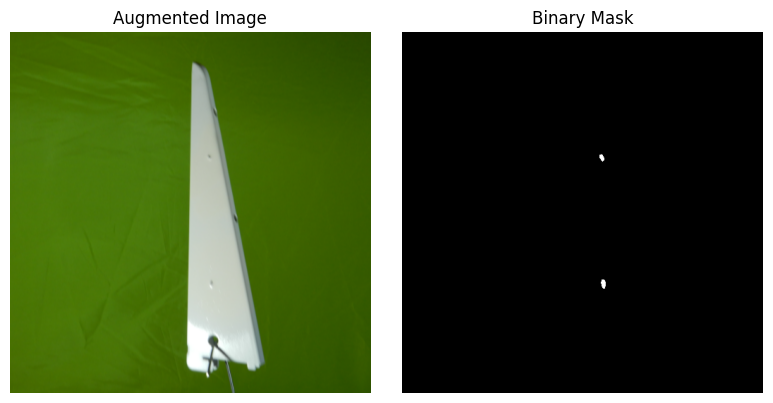

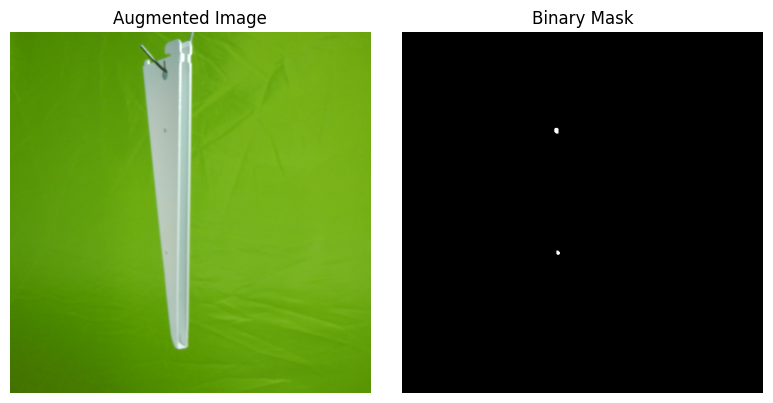

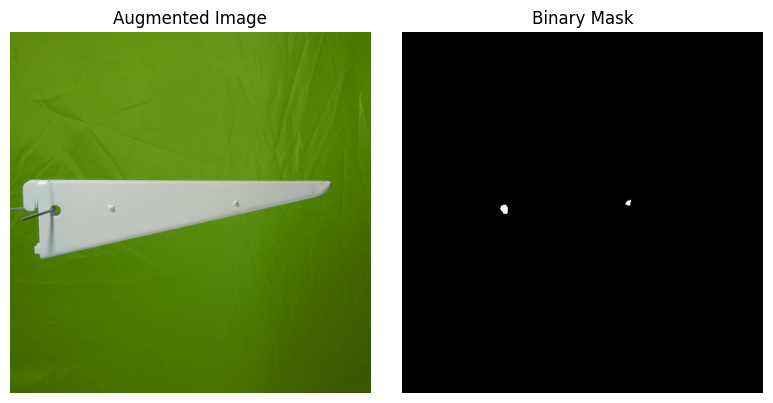

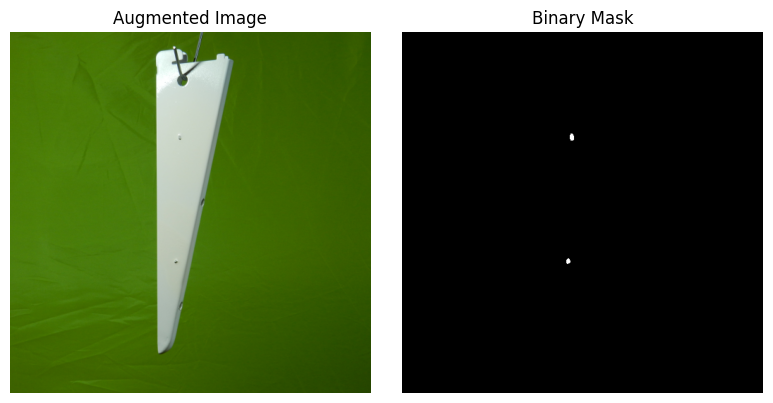

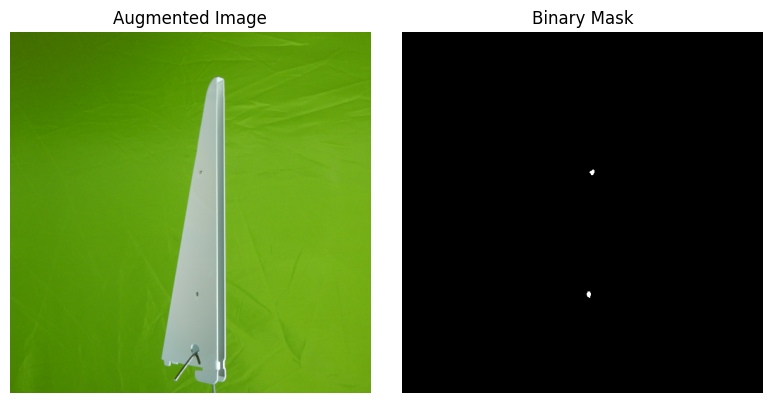

In [28]:
from torch.utils.data import DataLoader
DATA_DIR = '../data/bracket_white'
defect_types = ['defective_painting', 'scratches', 'good']
image_paths, mask_paths = get_combined_image_mask_pairs(DATA_DIR, defect_types)

dataset = SegmentationDataset(image_paths, mask_paths, transform=train_transform)

import matplotlib.pyplot as plt
import torch

def show_batch_images(dataset, num_samples=5):
    for i in range(num_samples):
        image, mask = dataset[i] 
        image_np = image.permute(1, 2, 0).cpu().numpy()  
        mask_np = mask.squeeze().cpu().numpy()          # [H, W]

        fig, ax = plt.subplots(1, 2, figsize=(8, 4))
        ax[0].imshow(image_np)
        ax[0].set_title("Augmented Image")
        ax[0].axis("off")

        ax[1].imshow(mask_np, cmap='gray')
        ax[1].set_title("Binary Mask")
        ax[1].axis("off")

        plt.tight_layout()
        plt.show()

show_batch_images(dataset)

